# GVB Data

## Table of Contents
1. [Imports](#imports)
2. [Import Data](#importData)
3. [Filter Data](#filter)
    1. [Arrivals](#filterArrivals)
         1. [Nieuwmarkt](#arrivalsNieuwmarkt)
         2. [Nieuwezijdse Kolk](#arrivalsNieuwezijds)
         3. [Dam](#arrivalsDam)
         4. [Spui](#arrivalsSpui)
         5. [Merge Arrivals](#arrivalsMerge)
    2. [Departures](#filterDepartures)
        1. [Nieuwmarkt](#departuresNieuwmarkt)
        2. [Nieuwezijdse Kolk](#departuresNieuwezijds)
        3. [Dam](#departuresDam)
        4. [Spui](#departuresSpui)
        5. [Merge Departures](#departuresMerge)
    3. [Merge Departues and Arrivals](#filterMerge)
4. [Construction DataFrame](#construction)
    1. [Data to Dict](#constructionDict)
5. [Final DataFrame](#FinalDF)
6. [DataFrame To CSV](#CSV)

## Imports <a name="imports"></a>

In [9]:
# For JSON imports
import json

#For DF, CSV, Excel
import pandas as pd

import re
import datetime

#Visualizations
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

## Import the data <a name="importData"></a>

In [18]:
#Import dataset
arr_df = pd.read_csv("../../../Data_thesis/GVB/Datalab_Reis_Bestemming_Uur_20190402.csv", sep=";")
dep_df = pd.read_csv("../../../Data_thesis/GVB/Datalab_Reis_Herkomst_Uur_20190403.csv", sep=";")

#Rename 'AantalReizen' column
arr_df = arr_df.rename(index=str, columns={"AantalReizen": "NumberOfArrivals", "Datum": "Date",
                                           "UurgroepOmschrijving (van aankomst)": "Hour", 
                                           "AankomstLat": "AankomstLon", "AankomstLon": "AankomstLat"})
dep_df = dep_df.rename(index=str, columns={"AantalReizen": "NumberOfDepartures", "Datum": "Date",
                                           "UurgroepOmschrijving (van vertrek)": "Hour",
                                          "VertrekLat": "VertrekLon", "VertrekLon": "VertrekLat"})

In [10]:
road_map = gpd.read_file("../../../Data_thesis/EventShapeFiles/roads.shp")

## Filter Data <a name="filter"></a>

In [19]:
#Selection of stations to use
stations = ["Nieuwmarkt", "Nieuwezijds Kolk", "Dam", "Spui"]

#Select rows that contain one of the listed stations in Aankomst
arr_df = arr_df[arr_df["AankomstHalteNaam"].isin(stations)]

#Select rows that contain one of the listed stations in Vertrek
dep_df = dep_df[dep_df["VertrekHalteNaam"].isin(stations)]

### Visualization

In [11]:
crs = {"init": "epsg:4326"}

#Create a point object -> Point is essentially a single object that describes the longitude and latitude of a data-point
geometry = [Point(xy) for xy in zip(arr_df["AankomstLon"], arr_df["AankomstLat"])]

geo_df = gpd.GeoDataFrame(arr_df,
                         crs = crs,
                         geometry = geometry)

In [12]:
geo_df.head()

,Date,Hour,AankomstHalteCode,AankomstHalteNaam,AankomstLon,AankomstLat,NumberOfArrivals,geometry
0,1/1/2018 12:00:00 AM,00:00 - 00:59,NaN,Overig,NaN,NaN,30,POINT (nan nan)
1,1/1/2018 12:00:00 AM,01:00 - 01:59,NaN,Overig,NaN,NaN,592,POINT (nan nan)
2,1/1/2018 12:00:00 AM,01:00 - 01:59,01005,Volendammerweg,4.956804,52.393062,12,POINT (4.95680438 52.39306199)
3,1/1/2018 12:00:00 AM,01:00 - 01:59,01059,Purmerplein,4.945694,52.390460,11,POINT (4.94569441 52.39045962)
4,1/1/2018 12:00:00 AM,01:00 - 01:59,ASA,Amstelstation,4.917514,52.346473,89,POINT (4.91751426 52.34647326)


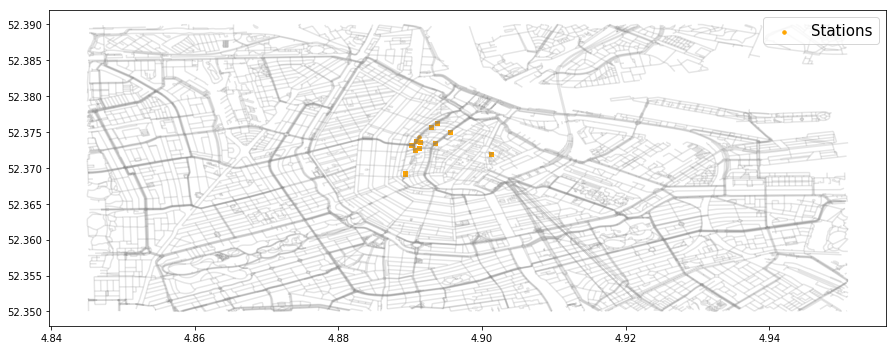

In [13]:
fig,ax = plt.subplots(figsize = (15, 15))
road_map.plot(ax = ax, alpha = 0.2, color = "grey")
geo_df[geo_df["AankomstHalteNaam"].isin(stations)].plot(ax = ax, markersize = 12, color = "orange", marker = "o", 
                                                        label = "Stations")
plt.legend(prop={"size": 15})

### Arrivals <a name="filterArrivals"></a>

In [20]:
arr_df.head()

,Date,Hour,AankomstHalteCode,AankomstHalteNaam,AankomstLon,AankomstLat,NumberOfArrivals
12,1/1/2018 12:00:00 AM,01:00 - 01:59,NMT,Nieuwmarkt,4.901239,52.371942,11
34,1/1/2018 12:00:00 AM,02:00 - 02:59,05055,Dam,4.890080,52.373127,21
68,1/1/2018 12:00:00 AM,02:00 - 02:59,NMT,Nieuwmarkt,4.901239,52.371942,48
92,1/1/2018 12:00:00 AM,03:00 - 03:59,05055,Dam,4.890080,52.373127,13
93,1/1/2018 12:00:00 AM,03:00 - 03:59,05069,Nieuwezijds Kolk,4.893731,52.376288,16


#### Nieuwmarkt <a name="arrivalsNieuwmarkt"></a>

In [21]:
temp_df = arr_df[arr_df["AankomstHalteNaam"] == "Nieuwmarkt"]
nmt_codes = temp_df.AankomstHalteCode.unique()

arr_nmt_df = arr_df[arr_df["AankomstHalteCode"].isin(nmt_codes)]
arr_nmt_df = arr_nmt_df.rename(index=str, columns={"AankomstHalteCode": "NieuwmarktCode", "AankomstLat": "NieuwmarktLat", 
                                           "AankomstLon": "NieuwmarktLon", "NumberOfArrivals": "NieuwmarktArrivals"}
                              ).reset_index()
arr_nmt_df = arr_nmt_df.drop(columns=["AankomstHalteNaam"])

NieuwmarktCode = arr_nmt_df["NieuwmarktCode"][0]
NieuwmarktLat = arr_nmt_df["NieuwmarktLat"][0]
NieuwmarktLon = arr_nmt_df["NieuwmarktLon"][0]

In [22]:
arr_nmt_df.head()

,index,Date,Hour,NieuwmarktCode,NieuwmarktLon,NieuwmarktLat,NieuwmarktArrivals
0,12,1/1/2018 12:00:00 AM,01:00 - 01:59,NMT,4.901239,52.371942,11
1,68,1/1/2018 12:00:00 AM,02:00 - 02:59,NMT,4.901239,52.371942,48
2,118,1/1/2018 12:00:00 AM,03:00 - 03:59,NMT,4.901239,52.371942,10
3,153,1/1/2018 12:00:00 AM,04:00 - 04:59,NMT,4.901239,52.371942,16
4,192,1/1/2018 12:00:00 AM,05:00 - 05:59,NMT,4.901239,52.371942,17


#### Nieuwezijdse Kolk <a name="arrivalsNieuwezijds"></a>

In [23]:
#All the station codes
temp_df = arr_df[arr_df["AankomstHalteNaam"] == "Nieuwezijds Kolk"]
nwk_codes = temp_df.AankomstHalteCode.unique()

#Make a subset of all the stations that have the given code(s)
arr_nwk_df = arr_df[arr_df["AankomstHalteCode"].isin(nwk_codes)]

#Rename the columns
arr_nwk_df = arr_nwk_df.rename(index=str, columns={"AankomstHalteCode": "NieuwezijdsCode", "AankomstLat": "NieuwezijdsLat", 
                                           "AankomstLon": "NieuwezijdsLon", "NumberOfArrivals": "NieuwezijdsArrivals"})

#Drop the name column
arr_nwk_df = arr_nwk_df.drop(columns=["AankomstHalteNaam"])

#Combine the arrivlas of multiple codes at the same time and date
arr_nwk_df = arr_nwk_df.groupby(["Date", "Hour"]).agg({"NieuwezijdsCode": 'first',
                                               "NieuwezijdsLat": 'first',
                                               "NieuwezijdsLon": 'first',
                                               "NieuwezijdsArrivals": 'sum'}).reset_index()

NieuwezijdsCode = arr_nwk_df["NieuwezijdsCode"][0]
NieuwezijdsLat = arr_nwk_df["NieuwezijdsLat"][0]
NieuwezijdsLon = arr_nwk_df["NieuwezijdsLon"][0]

#### Dam <a name="arrivalsDam"></a>

In [24]:
#All the station codes
temp_df = arr_df[arr_df["AankomstHalteNaam"] == "Dam"]
dam_codes = temp_df.AankomstHalteCode.unique()

#Make a subset of all the stations that have the given code(s)
arr_dam_df = arr_df[arr_df["AankomstHalteCode"].isin(dam_codes)]

#Rename the columns
arr_dam_df = arr_dam_df.rename(index=str, columns={"AankomstHalteCode": "DamCode", "AankomstLat": "DamLat", 
                                           "AankomstLon": "DamLon", "NumberOfArrivals": "DamArrivals"})

#Drop the name column
arr_dam_df = arr_dam_df.drop(columns=["AankomstHalteNaam"])

#Combine the arrivlas of multiple codes at the same time and date
arr_dam_df = arr_dam_df.groupby(["Date", "Hour"]).agg({"DamCode": 'first',
                                               "DamLat": 'first',
                                               "DamLon": 'first',
                                               "DamArrivals": 'sum'}).reset_index()

DamCode = arr_dam_df["DamCode"][0]
DamLat = arr_dam_df["DamLat"][0]
DamLon = arr_dam_df["DamLon"][0]

#### Spui <a name="arrivalsSpui"></a>

In [25]:
#All the station codes
temp_df = arr_df[arr_df["AankomstHalteNaam"] == "Spui"]
spui_codes = temp_df.AankomstHalteCode.unique()

#Make a subset of all the stations that have the given code(s)
arr_spui_df = arr_df[arr_df["AankomstHalteCode"].isin(spui_codes)]

#Rename the columns
arr_spui_df = arr_spui_df.rename(index=str, columns={"AankomstHalteCode": "SpuiCode", "AankomstLat": "SpuiLat", 
                                           "AankomstLon": "SpuiLon", "NumberOfArrivals": "SpuiArrivals"})

#Drop the name column
arr_spui_df = arr_spui_df.drop(columns=["AankomstHalteNaam"])

#Combine the arrivlas of multiple codes at the same time and date
arr_spui_df = arr_spui_df.groupby(["Date", "Hour"]).agg({"SpuiCode": 'first',
                                               "SpuiLat": 'first',
                                               "SpuiLon": 'first',
                                               "SpuiArrivals": 'sum'}).reset_index()

SpuiCode = arr_spui_df["SpuiCode"][0]
SpuiLat = arr_spui_df["SpuiLat"][0]
SpuiLon = arr_spui_df["SpuiLon"][0]

#### Merge DataFrames <a name="arrivalsMerge"></a>

In [26]:
arrivals_1 = pd.merge(arr_nmt_df, arr_nwk_df, on=["Date", "Hour"], how="outer")
arrivals_2 = pd.merge(arr_dam_df, arr_spui_df, on=["Date", "Hour"], how="outer")
arrivals = pd.merge(arrivals_1, arrivals_2, on=["Date", "Hour"], how="outer")

In [27]:
arrivals.head()

,index,Date,Hour,NieuwmarktCode,NieuwmarktLon,NieuwmarktLat,NieuwmarktArrivals,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,NieuwezijdsArrivals,DamCode,DamLat,DamLon,DamArrivals,SpuiCode,SpuiLat,SpuiLon,SpuiArrivals
0,12,1/1/2018 12:00:00 AM,01:00 - 01:59,NMT,4.901239,52.371942,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,68,1/1/2018 12:00:00 AM,02:00 - 02:59,NMT,4.901239,52.371942,48.0,NaN,NaN,NaN,NaN,05055,52.373127,4.89008,21.0,NaN,NaN,NaN,NaN
2,118,1/1/2018 12:00:00 AM,03:00 - 03:59,NMT,4.901239,52.371942,10.0,05069,52.376288,4.893731,16.0,05055,52.373127,4.89008,13.0,NaN,NaN,NaN,NaN
3,153,1/1/2018 12:00:00 AM,04:00 - 04:59,NMT,4.901239,52.371942,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,192,1/1/2018 12:00:00 AM,05:00 - 05:59,NMT,4.901239,52.371942,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Departures <a name="filterDepartures"></a>

In [28]:
dep_df.head()

,Date,Hour,VertrekHalteCode,VertrekHalteNaam,VertrekLon,VertrekLat,NumberOfDepartures
6,1/1/2018 12:00:00 AM,01:00 - 01:59,05070,Nieuwezijds Kolk,4.892841,52.375754,27
18,1/1/2018 12:00:00 AM,01:00 - 01:59,NMT,Nieuwmarkt,4.901239,52.371942,340
29,1/1/2018 12:00:00 AM,02:00 - 02:59,05068,Dam,4.891241,52.374363,39
30,1/1/2018 12:00:00 AM,02:00 - 02:59,05070,Nieuwezijds Kolk,4.892841,52.375754,130
55,1/1/2018 12:00:00 AM,02:00 - 02:59,NMT,Nieuwmarkt,4.901239,52.371942,175


#### Nieuwmarkt <a name="departuresNieuwmarkt"></a>

In [29]:
temp_df = dep_df[dep_df["VertrekHalteNaam"] == "Nieuwmarkt"]
nmt_codes = temp_df.VertrekHalteCode.unique()

dep_nmt_df = dep_df[dep_df["VertrekHalteCode"].isin(nmt_codes)]
dep_nmt_df = dep_nmt_df.rename(index=str, columns={"NumberOfDepartures": "NieuwmarktDepartures"})
dep_nmt_df = dep_nmt_df.drop(columns=["VertrekHalteNaam", "VertrekHalteCode", "VertrekLat", "VertrekLon"])

In [30]:
dep_nmt_df.head()

,Date,Hour,NieuwmarktDepartures
18,1/1/2018 12:00:00 AM,01:00 - 01:59,340
55,1/1/2018 12:00:00 AM,02:00 - 02:59,175
96,1/1/2018 12:00:00 AM,03:00 - 03:59,137
123,1/1/2018 12:00:00 AM,04:00 - 04:59,48
156,1/1/2018 12:00:00 AM,05:00 - 05:59,56


#### Nieuwezijdse Kolk <a name="departuresNieuwezijds"></a>

In [31]:
#All the station codes
temp_df = dep_df[dep_df["VertrekHalteNaam"] == "Nieuwezijds Kolk"]
nwk_codes = temp_df.VertrekHalteCode.unique()

#Make a subset of all the stations that have the given code(s)
dep_nwk_df = dep_df[dep_df["VertrekHalteCode"].isin(nwk_codes)]

#Rename the columns
dep_nwk_df = dep_nwk_df.rename(index=str, columns={"NumberOfDepartures": "NieuwezijdsDepartures"})

#Combine the arrivlas of multiple codes at the same time and date
dep_nwk_df = dep_nwk_df.groupby(["Date", "Hour"]).agg({"NieuwezijdsDepartures": 'sum'}).reset_index()

#### Dam <a name="departuresDam"></a>

In [32]:
#All the station codes
temp_df = dep_df[dep_df["VertrekHalteNaam"] == "Dam"]
dam_codes = temp_df.VertrekHalteCode.unique()

#Make a subset of all the stations that have the given code(s)
dep_dam_df = dep_df[dep_df["VertrekHalteCode"].isin(dam_codes)]

#Rename the columns
dep_dam_df = dep_dam_df.rename(index=str, columns={"NumberOfDepartures": "DamDepartures"})

#Combine the arrivlas of multiple codes at the same time and date
dep_dam_df = dep_dam_df.groupby(["Date", "Hour"]).agg({"DamDepartures": 'sum'}).reset_index()

#### Spui <a name="departuresSpui"></a>

In [33]:
#All the station codes
temp_df = dep_df[dep_df["VertrekHalteNaam"] == "Spui"]
spui_codes = temp_df.VertrekHalteCode.unique()

#Make a subset of all the stations that have the given code(s)
dep_spui_df = dep_df[dep_df["VertrekHalteCode"].isin(spui_codes)]

#Rename the columns
dep_spui_df = dep_spui_df.rename(index=str, columns={"NumberOfDepartures": "SpuiDepartures"})

#Combine the arrivlas of multiple codes at the same time and date
dep_spui_df = dep_spui_df.groupby(["Date", "Hour"]).agg({"SpuiDepartures": 'sum'}).reset_index()

#### Merge DataFrames <a name="departuresMerge"></a>

In [34]:
departures_1 = pd.merge(dep_nmt_df, dep_nwk_df, on=["Date", "Hour"], how="outer")
departures_2 = pd.merge(dep_dam_df, dep_spui_df, on=["Date", "Hour"], how="outer")
departures = pd.merge(departures_1, departures_2, on=["Date", "Hour"], how="outer")

In [35]:
departures.head()

,Date,Hour,NieuwmarktDepartures,NieuwezijdsDepartures,DamDepartures,SpuiDepartures
0,1/1/2018 12:00:00 AM,01:00 - 01:59,340.0,27.0,NaN,NaN
1,1/1/2018 12:00:00 AM,02:00 - 02:59,175.0,130.0,39.0,NaN
2,1/1/2018 12:00:00 AM,03:00 - 03:59,137.0,17.0,48.0,NaN
3,1/1/2018 12:00:00 AM,04:00 - 04:59,48.0,46.0,34.0,NaN
4,1/1/2018 12:00:00 AM,05:00 - 05:59,56.0,NaN,20.0,NaN


### Merge Arrivals and Departures <a name="filterMerge"></a>

In [36]:
full = pd.merge(arrivals, departures, on=["Date", "Hour"], how="outer")

In [37]:
#Reorder the columns
cols= ["Date", "Hour", "NieuwmarktCode", "NieuwmarktLat", "NieuwmarktLon", "NieuwmarktArrivals", 
            "NieuwmarktDepartures", "NieuwezijdsCode", "NieuwezijdsLat", "NieuwezijdsLon", "NieuwezijdsArrivals",
            "NieuwezijdsDepartures", "DamCode", "DamLat", "DamLon", "DamArrivals", "DamDepartures", "SpuiCode", "SpuiLat",
            "SpuiLon", "SpuiArrivals", "SpuiDepartures"]

full = full[cols]

#Replace the NaN value with 0
full = full.fillna(0.0)

#Add columns
#Gives day in numbers --> 0: Monday, 1: Tuesday,..., 6: Sunday
full["weekday"] = 99

#Adds whether day is weekend --> Day 5 and 6
full["is_weekend"] = 0

In [38]:
full.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,DamLon,DamArrivals,DamDepartures,SpuiCode,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend
0,1/1/2018 12:00:00 AM,01:00 - 01:59,NMT,52.371942,4.901239,11.0,340.0,0,0.000000,0.000000,...,0.00000,0.0,0.0,0,0.0,0.0,0.0,0.0,99,0
1,1/1/2018 12:00:00 AM,02:00 - 02:59,NMT,52.371942,4.901239,48.0,175.0,0,0.000000,0.000000,...,4.89008,21.0,39.0,0,0.0,0.0,0.0,0.0,99,0
2,1/1/2018 12:00:00 AM,03:00 - 03:59,NMT,52.371942,4.901239,10.0,137.0,05069,52.376288,4.893731,...,4.89008,13.0,48.0,0,0.0,0.0,0.0,0.0,99,0
3,1/1/2018 12:00:00 AM,04:00 - 04:59,NMT,52.371942,4.901239,16.0,48.0,0,0.000000,0.000000,...,0.00000,0.0,34.0,0,0.0,0.0,0.0,0.0,99,0
4,1/1/2018 12:00:00 AM,05:00 - 05:59,NMT,52.371942,4.901239,17.0,56.0,0,0.000000,0.000000,...,0.00000,0.0,20.0,0,0.0,0.0,0.0,0.0,99,0


## Construct Dataframes <a name="construction"></a>
Now that the contents is clear, we construct Dataframes for each station that is of interest to us. 

### Columns

**Arrival and Departure Stations:**
- *Metro*
    - Nieuwmarkt
- *Tram*
    - Nieuwezijdse Kolk
    - Dam
    - Spui
- *Type*: String

**Weekday:** Select the day number of the week, based on the given date
- *Type*: Int

**Weekend:** 1 if day is a weekend day
- *Type*: Binary

### Data to Dict <a name="constructionDict"></a>
Needed to ease certain operations

In [39]:
#DF to dict
full_dict = full.to_dict("index")

In [40]:
#Datetime format
date_format_1 = '%d/%m/%Y %H:%M:%S'
date_format_2 = '%m/%d/%Y %H:%M:%S'

#Loop over dict
for k, v in full_dict.items():
    #Replace time string with time blok
    time_blok = v["Hour"][:5]
    time_blok = re.sub('[:]', '', time_blok)
    v["Hour"] = int(time_blok)
    
    try:
        #Remove AM/PM from string
        v["Date"] = v["Date"][:-3]
        try:
            #Transform the date string to datatime.date object
            date = datetime.datetime.strptime(v["Date"], date_format_1)
            #Transfrom date to weekday number
            v["weekday"] = date.weekday()
        except:
            #Transform the date string to datatime.date object
            date = datetime.datetime.strptime(v["Date"], date_format_2)
            
            #Transfrom date to weekday number
            v["weekday"] = date.weekday()
        v["Date"] = date.date()
    except:
          v["weekday"] = 99  
    
    #Check if weekday is in the weekend
    if date.weekday() == 5 or date.weekday() == 6:
        v["is_weekend"] = 1
        
    v["Date"] = date.date()
    
    # Change station code and coordinates 
    #Nieuwmarkt
    v["NieuwmarktCode"] = NieuwmarktCode
    v["NieuwmarktLat"] = NieuwmarktLat
    v["NieuwmarktLon"] = NieuwmarktLon
    
    #Nieuwezijdse Kolk
    v["NieuwezijdsCode"] = NieuwezijdsCode
    v["NieuwezijdsLat"] = NieuwezijdsLat
    v["NieuwezijdsLon"] = NieuwezijdsLon
    
    #Dam
    v["DamCode"] = DamCode
    v["DamLat"] = DamLat
    v["DamLon"] = DamLon
    
    #Spui
    v["SpuiCode"] = SpuiCode
    v["SpuiLat"] = SpuiLat
    v["SpuiLon"] = SpuiLon

In [41]:
#Return to dict
full = pd.DataFrame.from_dict(full_dict, orient="index")

## Final DataFrame <a name="FinalDF"></a>
Make the model with the GVB data from *Dam* station

Variables final df:
- *Date*
    - Date the contents was gathered
    - Datetime object
- *Hour*
    - The hour the counts were gathered --> 100 means 01:00
    - int
- *Code*
    - Code of the station
    - str
- *Lat*
    - Latitude station
    - int
- *Lon*
    - Longitude station
    - int
- *weekday*
    - Day of the week in numbers --> 0: Monday, 1: Tuesday,..., 6: Sunday
    - int
- *is_weekend*
    - Whether is it is weekend or not
    - binary
- *Arrivals*
    - Number of passengers that travelled to the station
    - int
- *Departures*
    - Number of passengers that travelled from the station
    - int 

In [42]:
full.head()

,Date,Hour,NieuwmarktCode,NieuwmarktLat,NieuwmarktLon,NieuwmarktArrivals,NieuwmarktDepartures,NieuwezijdsCode,NieuwezijdsLat,NieuwezijdsLon,...,DamLon,DamArrivals,DamDepartures,SpuiCode,SpuiLat,SpuiLon,SpuiArrivals,SpuiDepartures,weekday,is_weekend
0,2018-01-01,100,NMT,52.371942,4.901239,11.0,340.0,05069,52.376288,4.893731,...,4.89008,0.0,0.0,05062,52.369097,4.889259,0.0,0.0,0,0
1,2018-01-01,200,NMT,52.371942,4.901239,48.0,175.0,05069,52.376288,4.893731,...,4.89008,21.0,39.0,05062,52.369097,4.889259,0.0,0.0,0,0
2,2018-01-01,300,NMT,52.371942,4.901239,10.0,137.0,05069,52.376288,4.893731,...,4.89008,13.0,48.0,05062,52.369097,4.889259,0.0,0.0,0,0
3,2018-01-01,400,NMT,52.371942,4.901239,16.0,48.0,05069,52.376288,4.893731,...,4.89008,0.0,34.0,05062,52.369097,4.889259,0.0,0.0,0,0
4,2018-01-01,500,NMT,52.371942,4.901239,17.0,56.0,05069,52.376288,4.893731,...,4.89008,0.0,20.0,05062,52.369097,4.889259,0.0,0.0,0,0


## Visualizations

In [43]:
vis_dict = full.to_dict("index")

In [63]:
#Nieuwmarkt
niew_arr = {}
niew_dep = {}

#Nieuwezijds
nwz_arr = {}
nwz_dep = {}

#Dam
dam_arr = {}
dam_dep = {}

#Spui
spui_arr = {}
spui_dep = {}

for k, v in vis_dict.items():
    
    #Combine date and time
    t = int(v["Hour"]/100)
    d = datetime.datetime.combine(v["Date"], datetime.time(t,0))
    
    #Nieuwmarkt
    niew_arr[d] = v["NieuwmarktArrivals"]
    niew_dep[d] = v["NieuwmarktDepartures"]
    
    #Nieuwezijds
    nwz_arr[d] = v["NieuwezijdsArrivals"]
    nwz_dep[d] = v["NieuwezijdsDepartures"]
    
    #Dam
    dam_arr[d] = v["DamArrivals"]
    dam_dep[d] = v["DamDepartures"]
    
    #Spui
    spui_arr[d] = v["SpuiArrivals"]
    spui_dep[d] = v["SpuiDepartures"]

In [64]:
#Nieuwmarkt
niew_arr_series = pd.Series(niew_arr)
niew_dep_series = pd.Series(niew_dep)

#Nieuwezijds
nwz_arr_series = pd.Series(nwz_arr)
nwz_dep_series = pd.Series(nwz_dep)

#Dam
dam_arr_series = pd.Series(dam_arr)
dam_dep_series = pd.Series(dam_dep)

#Spui
spui_arr_series = pd.Series(spui_arr)
spui_dep_series = pd.Series(spui_dep)

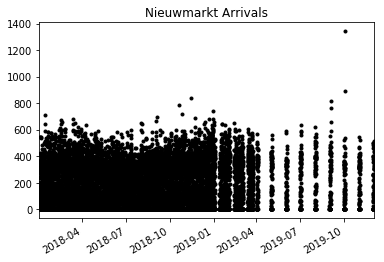

In [62]:
niew_arr_series.plot(style='k.', title="Nieuwmarkt Arrivals")
plt.show()

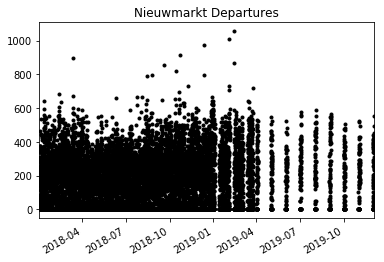

In [66]:
niew_dep_series.plot(style='k.', title="Nieuwmarkt Departures")
plt.show()

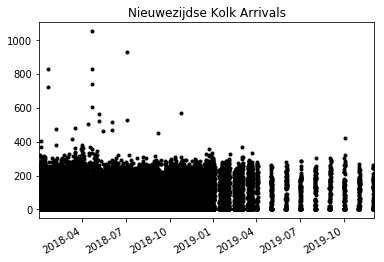

In [67]:
nwz_arr_series.plot(style="k.", title="Nieuwezijdse Kolk Arrivals")
plt.show()

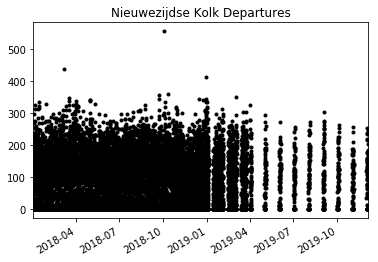

In [68]:
nwz_dep_series.plot(style="k.", title="Nieuwezijdse Kolk Departures")
plt.show()

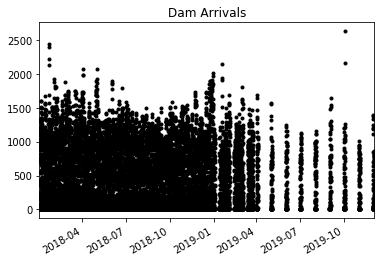

In [69]:
dam_arr_series.plot(style="k.", title="Dam Arrivals")
plt.show()

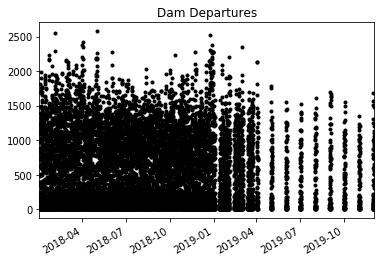

In [70]:
dam_dep_series.plot(style="k.", title="Dam Departures")
plt.show()

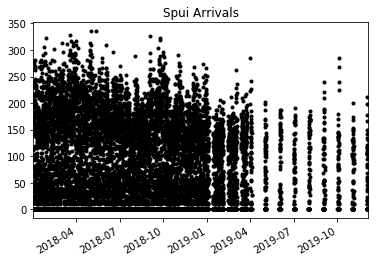

In [71]:
spui_arr_series.plot(style="k.", title="Spui Arrivals")
plt.show()

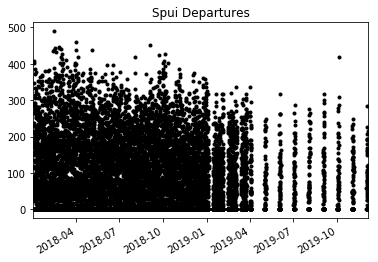

In [72]:
spui_dep_series.plot(style="k.", title="Spui Departures")
plt.show()

## DF to File <a name="CSV"></a>
Save the dataframe in a file, so that it can be imported for other uses. Later this will be probably be removed as the dataframe can simple function as input to another funtion. 

In [251]:
full.to_csv("../../../Data_thesis/Full_Datasets/GVB.csv", index=False)